# SDH Conference Paper Test Case 1

This tutorial shows how to let modesto solve a simple network.

## Imports and other stuff

In [1]:
from __future__ import division

import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto

In [2]:
%matplotlib notebook

In [3]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('Main.py')

## Network graph

A first step is to make a networkX object of the network you would like to optimize:

For the model to load correctly into modesto, you need to add some attributes to each of the nodes and edges.

For the nodes (besides the name of the node):
* **x, y, and z**: coordinates of the node in meter
* **comps**: a dictionary containing all components (except the network pipes) that are connected to the nodes. The keys of the dictionary are the names of the components, the values are the types of the components.

For the edges (besides names of the nodes where the edge starts and stops):
* **Name of the edge**
    

In [4]:
G = nx.DiGraph()

G.add_node('SolarArray', x=0, y=5000, z=0,
           comps={'solar': 'SolarThermalCollector'})

G.add_node('WaterscheiGarden', x=0, y=0,  z=0,
           comps={'neighb': 'BuildingFixed'})

G.add_node('p1', x=1000, y=2400, z=0, comps={})

G.add_node('p2', x=4000, y=2800, z=0, comps={})

G.add_node('TermienWest', x=4200, z=0, y=4600, 
           comps={'neighb': 'BuildingFixed'})

G.add_node('Production', x=6000, y=4000, z=0, comps={'backup': 'ProducerVariable'})
G.add_node('TermienEast', x=5400, y=200, z=0, comps={'neighb': 'BuildingFixed'})

In [5]:
G.add_edge('SolarArray', 'p1', name='servSol')
G.add_edge('p1', 'WaterscheiGarden', name='servWat')
G.add_edge('p1', 'p2', name='backBone')
G.add_edge('p2', 'TermienWest', name='servTer')
G.add_edge('p2', 'TermienEast', name='servBox')
G.add_edge('Production', 'p2', name='servPro')

<IPython.core.display.Javascript object>


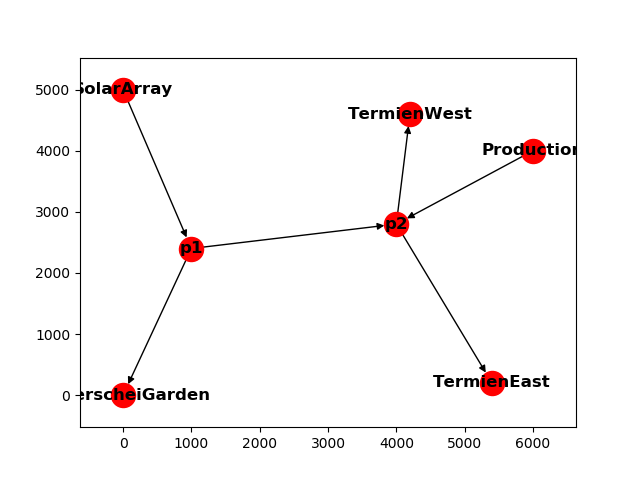

In [7]:
pos = {}
for node in G:
    #print node
    pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

fig, ax = plt.subplots()
nx.draw_networkx(G, with_labels=True, font_weight='bold', pos=pos, ax=ax)
fig.savefig('img/NetworkLayout.png', dpi=150)

## Setting up modesto

Decide the following characteristics of the optimization problem:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp). Currently, weather and prixe data for 2014 are available in modesto.
* **Pipe model**: The type of model used to model the pipes. Only one type can be selected for the whole optimization problem (unlike the component model types). Possibilities: SimplePipe (= perfect pipe, no losses, no time delays), ExtensivePipe (limited mass flows and heat losses, no time delays) and NodeMethod (heat losses and time delays, but requires mass flow rates to be known in advance)

In [8]:
horizon = 365*24*3600
time_step = 3600
start_time = pd.Timestamp('20140101')
pipe_model = 'ExtensivePipe'

And create the modesto object

In [9]:
optmodel = Modesto(horizon=horizon,
                   time_step=time_step,
                   pipe_model=pipe_model, 
                   graph=G,
                   start_time=start_time)

02-20 11:55 modesto.parameter.Parameter          INFO     Initializing Parameter Te
02-20 11:55 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
02-20 11:55 modesto.Node                         INFO     Initializing Node p2
02-20 11:55 modesto.Node                         INFO     Build of p2 finished
02-20 11:55 modesto.Node                         INFO     Initializing Node p1
02-20 11:55 modesto.Node                         INFO     Build of p1 finished
02-20 11:55 modesto.Node                         INFO     Initializing Node SolarArray
02-20 11:55 modesto.component.Component          INFO     Initializing Component solar
02-20 11:55 modesto.parameter.Parameter          INFO     Initializing Parameter area
02-20 11:55 modesto.parameter.Parameter          INFO     Initializing Parameter delta_T
02-20 11:55 modesto.parameter.Parameter          INFO     Initializing Parameter heat_profile
02-20 11:55 modesto.components.SolThermCol       INFO     Initializing So

## Adding data

modesto is now aware of the position and interconnections between components, nodes and edges, but still needs information rergarding, weather, prices, customer demands, component sizing, etc.


### Collect data

modesto provides some useful data handling methods (found in modesto.utils). Most notable is read_time_data, that can load time-variable data from a csv file. In this example, the data that is available in the folder modesto/Data is used.

#### Weather data:

In [10]:
from pkg_resources import resource_filename
datapath = resource_filename('modesto', 'Data')

In [11]:
wd = ut.read_time_data(datapath, name='Weather/weatherData.csv')
t_amb = wd['Te']
t_g = wd['Tg']

#### Electricity price

In [12]:
c_f = ut.read_time_data(path=datapath,name='ElectricityPrices/DAM_electricity_prices-2014_BE.csv')['price_BE']

### Changing parameters

In order to solve the problem, all parameters of the optimization probkem need to get a value. A list of the parameters that modesto needs and their description can be found with the following command:

In [13]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

Notice how all parameters are first grouped together in a dictionary and then given all at once to modesto.

If we print the parameters again, we can see the values have now been added:

In [14]:
building_params_common = {
    'delta_T': 40,
    'mult': 1        
}

heat_profile = ut.read_time_data(datapath, name='HeatDemand/HeatDemandFiltered.csv')

func = lambda s: s[:1].lower() + s[1:] if s else ''

for name in ['WaterscheiGarden', 'TermienWest', 'TermienEast']: #['Boxbergheide', 'TermienWest', 'WaterscheiGarden']:
    build_param = building_params_common
    build_param['heat_profile'] = heat_profile[func(name)]
    
    optmodel.change_params(build_param, node=name, comp='neighb')

The heat generation unit:

In [15]:
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               'Qmax': 8e7,
               'ramp_cost': 0.01,
               'ramp': 8e7 / 3600}

optmodel.change_params(prod_design, 'Production', 'backup')

The storage unit:

In [16]:
stor_design = {
    'Thi': 70 + 273.15,
    'Tlo': 30 + 273.15,
    'mflo_max': 110,
    'volume': 2e4,
    'ar': 1,
    'dIns': 0.3,
    'kIns': 0.024,
    'heat_stor': 0
}

#optmodel.change_params(dict=stor_design, node='BuildingAndStorage',
  #                     comp='storage')

And the pipes:

In [17]:
pipeDiam = {
    'backBone': 500,
    'servWat': 400,
    'servTer': 250,
    'servPro': 500,
    'servSol': 500,
    'servBox': 250
}

for pipe, DN in pipeDiam.iteritems():
    optmodel.change_param(node=None, comp=pipe, param='pipe_type', val=DN)

In [18]:
solData = ut.read_time_data(datapath, name='RenewableProduction/SolarThermalNew.csv')

solParam = {
    'delta_T': 40,
    'heat_profile': solData['0_40'],
    'area': 200000
}

optmodel.change_params(solParam, node='SolarArray', comp='solar')

## Solving the optimization problem

modesto now has all required data and can compile the problem. 

In [19]:
optmodel.compile()

02-20 11:55 modesto.component.Component          INFO     Optimization block for Pipe servWat initialized
02-20 11:55 modesto.component.Component          INFO     Optimization model Pipe servWat compiled
02-20 11:55 modesto.component.Component          INFO     Optimization block for Pipe backBone initialized
02-20 11:55 modesto.component.Component          INFO     Optimization model Pipe backBone compiled
02-20 11:55 modesto.component.Component          INFO     Optimization block for Pipe servBox initialized
02-20 11:55 modesto.component.Component          INFO     Optimization model Pipe servBox compiled
02-20 11:55 modesto.component.Component          INFO     Optimization block for Pipe servTer initialized
02-20 11:55 modesto.component.Component          INFO     Optimization model Pipe servTer compiled
02-20 11:55 modesto.component.Component          INFO     Optimization block for Pipe servPro initialized
02-20 11:55 modesto.component.Component          INFO     Optimization m

The objective of the optimization can be selected (like cost, energy or CO2):

In [20]:
optmodel.set_objective('cost')
optmodel.opt_settings(allow_flow_reversal=True)

Finally, the problem can be solved:

Currently, modesto is compatible with two solvers, namely `cplex` and `gurobi`. 

In [21]:
optmodel.solve(tee=True, mipgap=0.00001, solver='cplex', warmstart=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'c:\users\u0094934\appdata\local\temp\tmpiltty8.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 1e-05
CPLEX> New value for level of mixed integer node display: 3
CPLEX> Problem 'c:\users\u0094934\appdata\local\temp\tmpgjafgp.pyomo.lp' read.
Read time = 0.63 sec. (37.59 ticks)
CPLEX> Problem name         : c:\users\u0094934\appdata\local\temp\tmpgjafgp.pyomo.lp
Objective sense      : Minimize
Variables            :  262802  [Nneg: 26281,  Box: 8760,  Free: 227761]
Objective nonzeros   :    8761
Linear constraints   :  385439  [Less: 87596,  Greater: 52560,  Equal: 2

0

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective if an extra input is given (not necessarily active, hence not an optimal value).

In [22]:
print 'Active:', optmodel.get_objective()
print 'Energy:', optmodel.get_objective('energy')
print 'Cost:  ', optmodel.get_objective('cost')

Active: 7711494665.7
Energy: 205523135.071
Cost:   7711494665.7


modesto has the get_result method, whch allows to get the optimal values of the optimization variables:

### Buildings

Collecting the data for the Building.building component:

In [23]:
heat_flows = pd.DataFrame()

for node in ['TermienEast', 'TermienWest', 'WaterscheiGarden']:
    heat_flows[node] = optmodel.get_result('heat_flow', node=node, comp='neighb')

In [24]:
inputs = pd.DataFrame()

inputs['Production'] = optmodel.get_result('heat_flow', node='Production', comp='backup')
inputs['Solar'] = optmodel.get_result('heat_flow', node='SolarArray', comp='solar')

Creating plots:

<IPython.core.display.Javascript object>


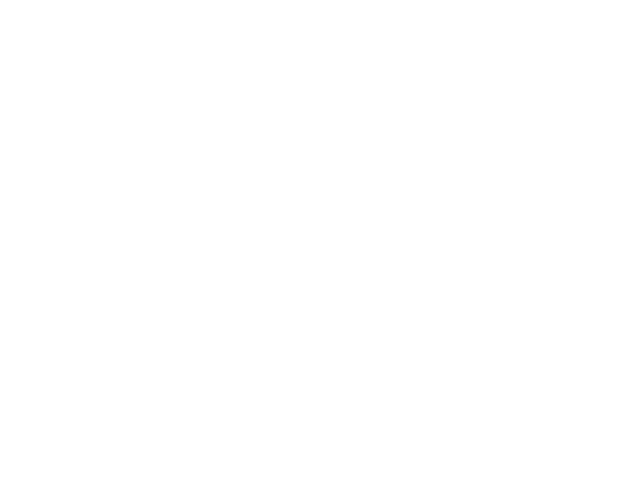

Text(0.5,0,u'Time')

In [25]:
#%matplotlib inline

fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(heat_flows)
ax[0].set_ylabel('Heat Flow [W]')
ax[0].legend(heat_flows.columns)

ax[1].plot(inputs)
ax[1].set_ylabel('Heat Flow [W]')
ax[1].legend(inputs.columns)

for a in ax:
    a.grid(linewidth=0.5, alpha=0.3)

ax[-1].set_xlabel('Time')

<IPython.core.display.Javascript object>


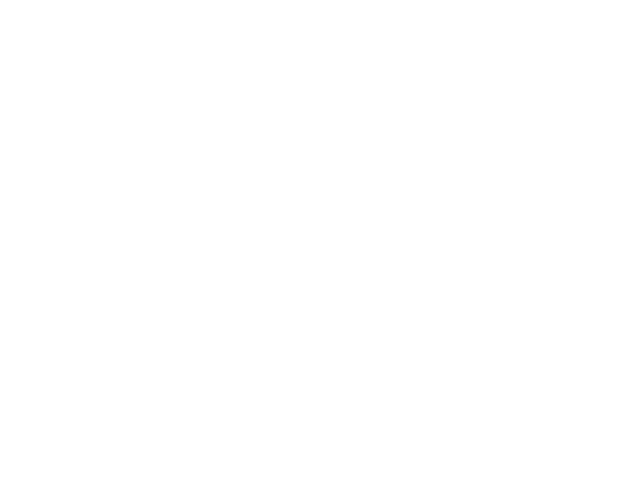

In [26]:
fig, ax = plt.subplots(1,1)
df = optmodel.get_result('heat_flow_curt', node='SolarArray', comp='solar')
plt.plot(df)

## Efficiency check

In [27]:
# Sum of heat flows
prod_e = sum(inputs['Production'])
prod_s = sum(inputs['Solar'])
waterschei_e = sum(heat_flows['WaterscheiGarden'])
termieneast_e = sum(heat_flows['TermienEast'])
termienwest_e = sum(heat_flows['TermienWest'])

# Efficiency
print '\nNetwork efficiency', (termieneast_e + waterschei_e + termienwest_e) / (prod_e + prod_s) * 100, '%'
    


Network efficiency 97.2545272604 %


In [28]:
print sum(optmodel.get_result('heat_flow_max', node='SolarArray', comp='solar'))*200000
print sum(optmodel.get_result('heat_flow', node='SolarArray', comp='solar'))   

24546074583.4
6780492966.09


## Check operation of pipes

In [29]:
weights = {}

for pipe in ['servTer', 'servBox','servWat']:#['backBone', 'servTer', 'servBox', 'servPro', 'servSol', 'servWat']:
    print pipe
    df= pd.DataFrame()
    for w in ['1','2','3','4']:
        print w
        df[w]=optmodel.get_result('weight'+w, comp=pipe)
    print df.min()
    df[df < 0] = 0
    weights[pipe] = df
    fig, ax = plt.subplots(1,1)
    ax.stackplot(df.index, [df[x].values for x in df], labels=df.columns)
    ax.legend()
    ax.set_title(pipe)

servTer
1


Exception: weight1 is not a valid parameter or variable of servTer

<IPython.core.display.Javascript object>


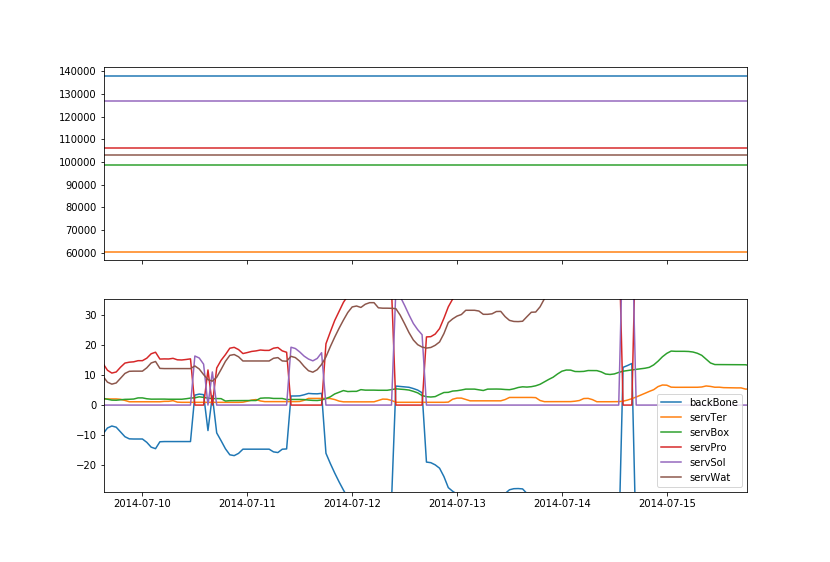

backBone
servTer
servBox
servPro
servSol
servWat


In [33]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, sharex=True)
for pipe in ['backBone', 'servTer', 'servBox', 'servPro', 'servSol', 'servWat']:
    print pipe
    axs[0].plot(optmodel.get_result('heat_loss_tot', comp=pipe), label=pipe)
    axs[1].plot(optmodel.get_result('mass_flow', comp=pipe), label=pipe)
plt.legend()

In [ ]:
for pipe in ['backBone', 'servTer', 'servBox', 'servPro', 'servSol', 'servWat']:
    print pipe, str(round(sum(optmodel.get_result('heat_loss_tot', comp=pipe))/1e6,2)), 'MWh'

* backBone -1049.81 MWh
* servTer 316.37 MWh
* servBox -515.85 MWh
* servPro 823.69 MWh
* servSol 80.02 MWh
* servWat 899.83 MWh

In [ ]:
mass_flows = pd.DataFrame()

mass_flows['Production'] = optmodel.get_result('mass_flow', node='Production', comp='backup')

In [ ]:
plt.plot(mass_flows)

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(inputs['Production'], label='Heat flow')
axs[0].plot(mass_flows['Production']*40*4180, label='$\dot{m}c_p\Delta T$')

axs[0].set_ylabel('Heat flow [W]')

axs[1].plot(inputs['Production'] - mass_flows['Production']*40*4180)
axs[1].set_ylabel('Difference [W]')

ax.legend()

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(inputs['Production']/(mass_flows['Production']*4180), label='Heat flow')
axs[0].axhline(40)
axs[0].set_ylim(0,100)

axs[0].set_ylabel('Heat flow [W]')

axs[1].semilogy(inputs['Production']/(mass_flows['Production']*4180) - 40)
axs[1].set_ylabel('Difference [W]')

ax.legend()